In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score,auc,roc_curve

In [2]:
#Import dữ liệu đã được tiền xử lí
df = pd.read_csv('../../../BankChurners_Preprocessing.csv')

## Chọn Attrition_Flag làm thuộc tính quyết định. Nhưng vì Attrition_Flag đang bị mất cân bằng dữ liệu. Vậy nên ta cần xử lí mất cân bằng trước

Tách dữ liệu thành 2 phần. 1 phần chứa các cột còn lại và cột chứa thuộc tính quyết định.
features: Chứa các thuộc tính còn lại.
labels: Chứa thuộc tính quyết định.

In [3]:
features=df.drop('Attrition_Flag',axis=1)
labels=df['Attrition_Flag']

Chuyển đổi các cột không phải dạng số trong biến features về dạng one-hot vector

In [4]:
features_onehot=pd.get_dummies(features,columns=features.select_dtypes(exclude=['int64']).columns)

In [5]:
#Chia tập dữ liệu theo train 70%, test 30%
X_train, X_test, y_train, y_test = train_test_split(features_onehot, labels, test_size=0.3, random_state=42,shuffle=True)

In [6]:
# Áp dụng kỹ thuật Undersampling để làm cân bằng dữ liệu
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

In [7]:
print(y_train_resampled.shape)
print(X_train_resampled.shape)

(2262,)
(2262, 21)


In [8]:
crf = RandomForestClassifier(random_state=0)

In [9]:
params= {
    'n_estimators': [int(x) for x in np.arange(start = 100, stop = 501, step = 50)],
    'max_depth': [int(x) for x in np.arange(start = 10, stop = 101, step = 10)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto','sqrt']
    }

In [10]:
crf_rd = RandomizedSearchCV(crf,
                                   param_distributions = params,
                                   n_iter = 25,              
                                   refit = "recall",
                                   return_train_score = False,
                                   random_state = 0,
                                   verbose = 2,
                                   cv = 3,
                                   n_jobs = -1) 

In [11]:
crf_rd=crf_rd.fit(X_train_resampled, y_train_resampled)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


In [12]:
crf_rd.best_params_

{'n_estimators': 350,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60}

In [13]:
crf_rd = RandomForestClassifier(n_estimators=350,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                max_features='sqrt',
                                max_depth=60,
                                bootstrap=True)

In [14]:
crf_rd.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=60, n_estimators=350)

In [15]:
rf_pred = crf_rd.predict(X_test)
rf_score=metrics.accuracy_score(y_test,rf_pred)
print("Accuracy:",rf_score)
print("Report:",metrics.classification_report(y_test,rf_pred))

Accuracy: 0.9016123724909509
Report:               precision    recall  f1-score   support

           0       0.64      0.93      0.76       496
           1       0.98      0.90      0.94      2543

    accuracy                           0.90      3039
   macro avg       0.81      0.91      0.85      3039
weighted avg       0.93      0.90      0.91      3039



Text(0.5, 1.0, 'Random Forest Accuracy Score : 0.9016123724909509')

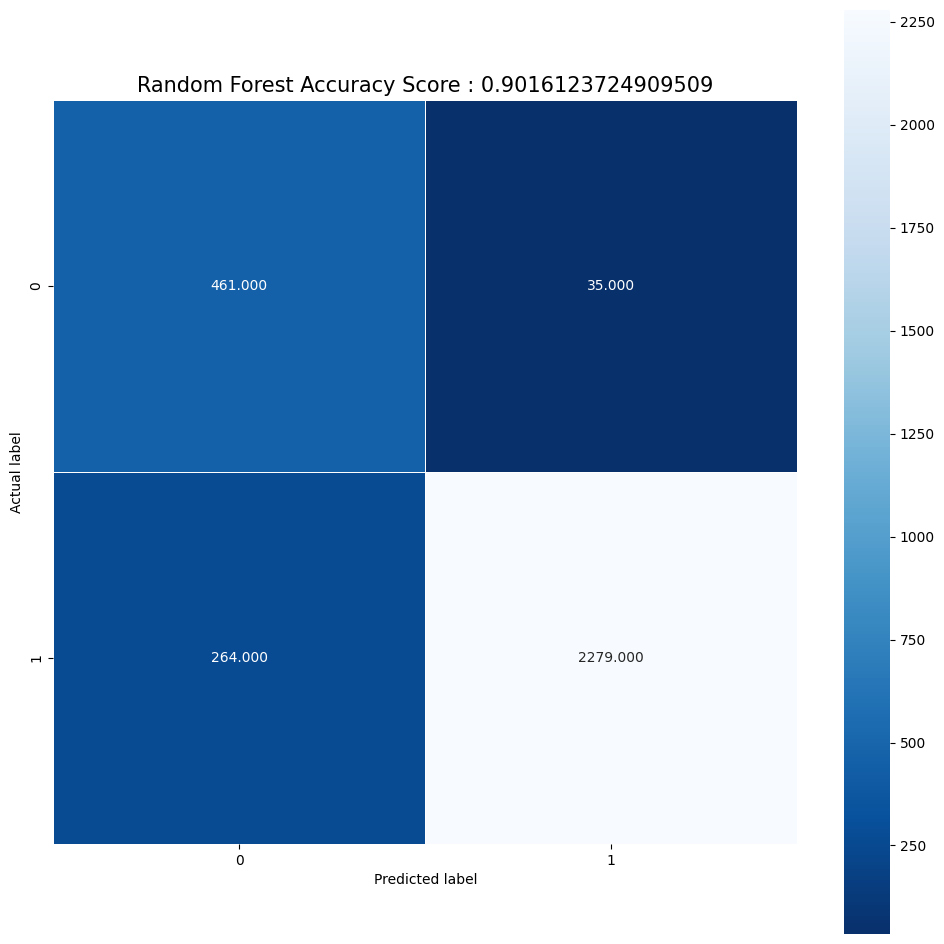

In [16]:
rf_cm=metrics.confusion_matrix(y_test,rf_pred)
plt.figure(figsize=(12,12))
sns.heatmap(rf_cm,annot=True,fmt=".3f",linewidths=.5,square=True,cmap="Blues_r")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Random Forest Accuracy Score : {0}'.format(rf_score)
plt.title(title,size=15)

TÍNH ROC AUC

In [17]:
# Dự đoán xác suất cho dữ liệu kiểm tra
y_true=y_test
y_probas = crf_rd.predict_proba(X_test)[:,1]

In [18]:
# Tính đường cong ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probas)
roc_auc = auc(fpr, tpr)

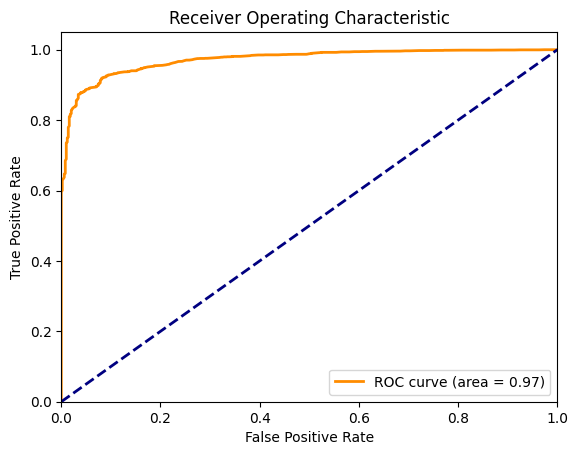

In [19]:
# Vẽ đường cong ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

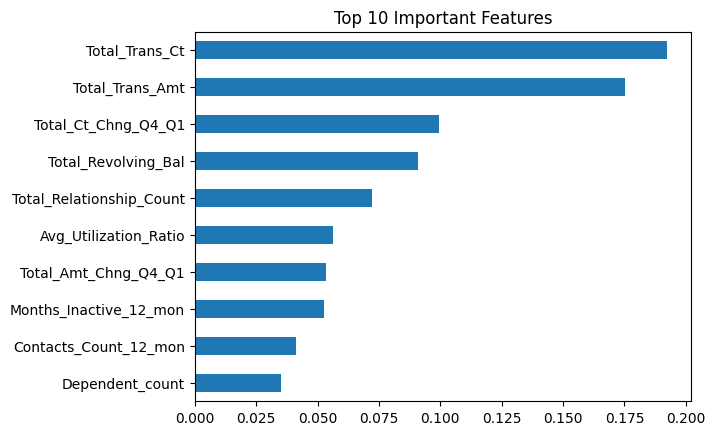

In [20]:
feat_importances = pd.Series(crf_rd.feature_importances_, index=X_train_resampled.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()